In [30]:
#import packages 
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
#read in data as df
#this dataframe has the z_score data but also the most likely subtype and stage for each patient
df = pd.read_csv(r'A:\Documents\NHANES\nhanes_zdata_with_subtypes.csv')
df

In [15]:
#check to see unique values that subtype and stage can take

print("Unique values for subtype:", df.ml_subtype.unique())
print("Unique values for stage:", df['ml_stage'].unique())

Unique values for subtype: [0. 3. 1. 2.]
Unique values for stage: [ 0.  1.  4.  2.  3.  7.  5.  6.  8.  9. 10. 12. 18. 14. 13. 15. 11.]


In [19]:
##lily to ask liam - why has no one been allocated to stages 16,17 or 19

df[df['ml_stage']== 18.]

,SEQN,l_500,l_1000,l_2000,l_4000,l_8000,Gender,Age,Race,HearingLoss,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0,prob_S1,prob_S2
315,1988,14.381591,14.397909,13.719129,14.281313,11.900695,Female,49,Mexican American,1,1.0,0.595742,18.0,0.340504,0.058493,0.595742,0.226588


In [20]:
# this includes all patients including normals. So now need to add 1 to each subtype and create a new subtype made up of just those in stage 0 
# make current subtypes (0 and 1) 1 and 2 instead
df.loc[:,'ml_subtype'] = df.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
df.loc[df.ml_stage==0,'ml_subtype'] = 0

In [21]:
df.ml_subtype.value_counts()

0.0    422
1.0    209
2.0    194
3.0    124
4.0     51
Name: ml_subtype, dtype: int64

In [29]:
print(sns.__version__)


0.10.0
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:


Keyring is skipped due to an exception: 'keyring.backends'
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\seaborn-0.10.0.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.



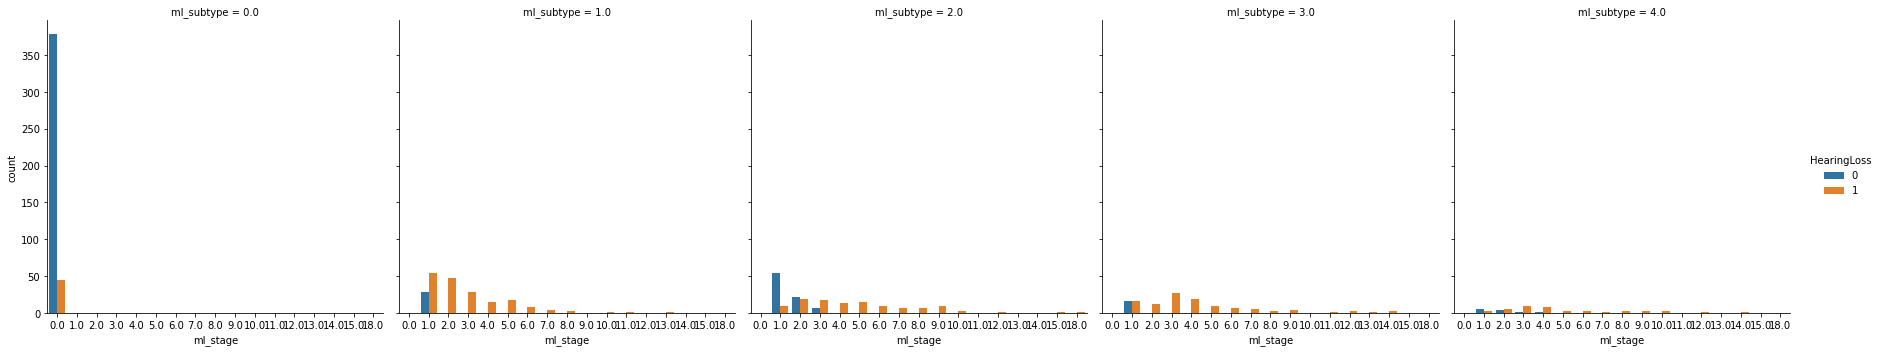

In [31]:
#sanity check to ensure all the controls are assigned to low stages/ predominately the new 0 subtype group

sns.catplot(x='ml_stage', hue='HearingLoss', data=df, col='ml_subtype', kind='count')

plt.show()

In [32]:
#characteristics of the subtypes excluding subtype 0

# Number of patients per subtype
grouped = df.groupby('ml_subtype').agg(
    count_patients=('ml_subtype', 'size'),
    mean_age=('Age', 'mean'),
    sd_age=('Age', 'std'),
    count_male=('Gender', lambda x: (x == 'Male').sum()),
    count_female=('Gender', lambda x: (x == 'Female').sum())
)

# Calculate proportion of males and females per subtype
grouped['prop_male'] = grouped['count_male'] / grouped['count_patients']
grouped['prop_female'] = grouped['count_female'] / grouped['count_patients']

# Display the grouped stats
print(grouped)

            count_patients   mean_age     sd_age  count_male  count_female  \
ml_subtype                                                                   
0.0                    422  36.485782  12.210293         154           268   
1.0                    209  49.397129  13.958737         120            89   
2.0                    194  45.536082  14.832440          81           113   
3.0                    124  49.185484  14.024002          90            34   
4.0                     51  45.529412  14.701501          27            24   

            prop_male  prop_female  
ml_subtype                          
0.0          0.364929     0.635071  
1.0          0.574163     0.425837  
2.0          0.417526     0.582474  
3.0          0.725806     0.274194  
4.0          0.529412     0.470588  


In [34]:
# 2. Statistical Tests

# ANOVA: Test if there's a significant difference in age between subtypes
f_stat, p_value_age = stats.f_oneway(
    df[df['ml_subtype'] == 1]['Age'],
    df[df['ml_subtype'] == 2]['Age'],
    df[df['ml_subtype'] == 3]['Age'],
    df[df['ml_subtype'] == 4]['Age']
)
print(f"ANOVA result for age: F-statistic = {f_stat}, p-value = {p_value_age}")

ANOVA result for age: F-statistic = 3.2825298527201583, p-value = 0.020601790740776435


In [35]:
# Chi-squared test: Test if there's a significant association between subtype and sex
contingency_table = pd.crosstab(df['ml_subtype'], df['Gender'])
chi2_stat, p_value_sex, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-squared test result for sex: Chi2-statistic = {chi2_stat}, p-value = {p_value_sex}")

Chi-squared test result for sex: Chi2-statistic = 63.20163867844757, p-value = 6.154135475406006e-13


In [40]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run the Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['Age'], groups=df['ml_subtype'], alpha=0.05)

print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  12.9113  0.001  9.7959 16.0268   True
   0.0    2.0   9.0503  0.001  5.8553 12.2453   True
   0.0    3.0  12.6997  0.001  8.9373 16.4621   True
   0.0    4.0   9.0436  0.001  3.5832  14.504   True
   1.0    2.0   -3.861 0.0337 -7.5332 -0.1889   True
   1.0    3.0  -0.2116    0.9 -4.3868  3.9635  False
   1.0    4.0  -3.8677  0.353 -9.6203  1.8849  False
   2.0    3.0   3.6494 0.1285 -0.5855  7.8843  False
   2.0    4.0  -0.0067    0.9 -5.8027  5.7894  False
   3.0    4.0  -3.6561 0.4788 -9.7832  2.4711  False
----------------------------------------------------


In [37]:
# Get contingency table for sex vs. subtype
contingency_table = pd.crosstab(df['ml_subtype'], df['Gender'])

# Loop through all pairs of subtypes and perform the Z-test
subtypes = contingency_table.index.tolist()
pairs = list(itertools.combinations(subtypes, 2))  # Get all subtype pairs

for pair in pairs:
    count = contingency_table.loc[list(pair), 'Male'].values  # Male counts
    nobs = contingency_table.loc[list(pair)].sum(axis=1).values  # Total counts (male + female)
    
    stat, p_val = proportions_ztest(count, nobs)
    print(f"Comparison {pair}: p-value = {p_val}")

Comparison (0.0, 1.0): p-value = 6.014307313915738e-07
Comparison (0.0, 2.0): p-value = 0.21192973547314486
Comparison (0.0, 3.0): p-value = 1.194592650140998e-12
Comparison (0.0, 4.0): p-value = 0.022444028632612585
Comparison (1.0, 2.0): p-value = 0.0016762921683725154
Comparison (1.0, 3.0): p-value = 0.005574007661896491
Comparison (1.0, 4.0): p-value = 0.5632451647446288
Comparison (2.0, 3.0): p-value = 7.534862176242883e-08
Comparison (2.0, 4.0): p-value = 0.15211595558643567
Comparison (3.0, 4.0): p-value = 0.012139636926416612
